# Negative Binomial Regression Modeling of Suicide Quantities vs. Cancer

The idea is to model the suicides quantity by means of a NB2 model.

This model admits only integer outputs. So, we won't use the suicide/occurences rates here.

To compensate, we set the municipality's population as a parameter to the model.

We want to verify if this model fits well to the data. If that's the case, we could model the suicide quantities similarly, and future predictions should be worth.

(It's based on the Poisson regression model, but doens't make any assumtions on output's distribution)

References:
- https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option('display.max_columns', 100)
%matplotlib inline
%pylab inline

C:\Users\marco\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\marco\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\marco\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\marco\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


Import datasets:

In [2]:
suicides = pd.read_csv('../Suicide/CSV/suicides_codmunres.csv')
population = pd.read_csv('../util/POPULATION_2017.csv', index_col=0)
municipalities = pd.read_csv('../util/CADMUN.csv')
cancer = pd.read_csv('CANCERBR2017.csv', index_col=0)

In [3]:
suicides.shape, population.shape, municipalities.shape, cancer.shape

((3149, 2), (5570, 2), (5652, 28), (5359, 2))

In [4]:
len(suicides[suicides['SUICIDES'] == 0])

0

Let's merge the files:

In [5]:
df = pd.merge(left=population, right=municipalities, left_on='MUNCOD', right_on='MUNCOD', how='left')
df = pd.merge(left=df, right=cancer, left_on='MUNCOD', right_on='MUNCOD', how='right')
df = pd.merge(left=df, right=suicides, left_on='MUNCOD', right_on='CODMUNRES', how='left')
df.shape

(5359, 32)

In [6]:
df.head()

,POPULATION,MUNCOD,MUNCODDV,SITUACAO,MUNSINP,MUNSIAFI,MUNNOME,MUNNOMEX,OBSERV,MUNSINON,MUNSINONDV,AMAZONIA,FRONTEIRA,CAPITAL,UFCOD,MESOCOD,MICROCOD,MSAUDCOD,RSAUDCOD,CSAUDCOD,RMETRCOD,AGLCOD,ANOINST,ANOEXT,SUCESSOR,LATITUDE,LONGITUDE,ALTITUDE,AREA,QUANTIDADE,CODMUNRES,SUICIDES
0,25437.0,110001.0,1100015.0,ATIVO,26016.0,33.0,Alta Floresta D'Oeste,ALTA FLORESTA D'OESTE,NaN,NaN,NaN,S,S,N,11.0,1102.0,11006.0,1190.0,1102.0,11900.0,1190.0,1190.0,1986.0,NaN,NaN,-11.929,-61.996,350.0,7066.702,25,110001.0,3.0
1,107345.0,110002.0,1100023.0,ATIVO,26004.0,7.0,Ariquemes,ARIQUEMES,NaN,NaN,NaN,S,N,N,11.0,1102.0,11003.0,1190.0,1104.0,11900.0,1190.0,1190.0,1977.0,NaN,NaN,-9.913,-63.041,142.0,4426.558,66,110002.0,10.0
2,6224.0,110003.0,1100031.0,ATIVO,26020.0,37.0,Cabixi,CABIXI,NaN,NaN,NaN,S,S,N,11.0,1102.0,11008.0,1190.0,1103.0,11900.0,1190.0,1190.0,1989.0,NaN,NaN,-13.492,-60.545,230.0,1314.355,4,NaN,NaN
3,88507.0,110004.0,1100049.0,ATIVO,26007.0,9.0,Cacoal,CACOAL,NaN,NaN,NaN,S,N,N,11.0,1102.0,11006.0,1190.0,1102.0,11900.0,1190.0,1190.0,1977.0,NaN,NaN,-11.438,-61.448,200.0,3792.638,133,110004.0,5.0
4,17934.0,110005.0,1100056.0,ATIVO,26014.0,27.0,Cerejeiras,CEREJEIRAS,NaN,NaN,NaN,S,S,N,11.0,1102.0,11008.0,1190.0,1103.0,11900.0,1190.0,1190.0,1983.0,NaN,NaN,-13.189,-60.812,277.0,2783.305,15,110005.0,1.0


In [7]:
df = df[['MUNCOD', 'POPULATION', 'CAPITAL', 'LATITUDE', 'LONGITUDE', 'ALTITUDE', 'AREA', 'QUANTIDADE', 'SUICIDES']]
df = df.rename(columns={"QUANTIDADE": "CANCER_QTT"})
df.head()

,MUNCOD,POPULATION,CAPITAL,LATITUDE,LONGITUDE,ALTITUDE,AREA,CANCER_QTT,SUICIDES
0,110001.0,25437.0,N,-11.929,-61.996,350.0,7066.702,25,3.0
1,110002.0,107345.0,N,-9.913,-63.041,142.0,4426.558,66,10.0
2,110003.0,6224.0,N,-13.492,-60.545,230.0,1314.355,4,NaN
3,110004.0,88507.0,N,-11.438,-61.448,200.0,3792.638,133,5.0
4,110005.0,17934.0,N,-13.189,-60.812,277.0,2783.305,15,1.0


In [8]:
(df['POPULATION'].isnull()).value_counts()

False    5354
True        5
Name: POPULATION, dtype: int64

In [9]:
df = df[~df['POPULATION'].isnull()]
(df['POPULATION'].isnull()).value_counts()

False    5354
Name: POPULATION, dtype: int64

As there's no municipality with 0 suicides, let's assume these ones have 0 suicides for the year of 2017.

In [10]:
df['MUNCOD'] = df['MUNCOD'].astype(np.int64)
df['POPULATION'] = df['POPULATION'].astype(np.int64)
df['SUICIDES'] = df['SUICIDES'].fillna(0).astype(np.int64)

In [11]:
df.head()

,MUNCOD,POPULATION,CAPITAL,LATITUDE,LONGITUDE,ALTITUDE,AREA,CANCER_QTT,SUICIDES
0,110001,25437,N,-11.929,-61.996,350.0,7066.702,25,3
1,110002,107345,N,-9.913,-63.041,142.0,4426.558,66,10
2,110003,6224,N,-13.492,-60.545,230.0,1314.355,4,0
3,110004,88507,N,-11.438,-61.448,200.0,3792.638,133,5
4,110005,17934,N,-13.189,-60.812,277.0,2783.305,15,1


To construct a **Baseline**, let's take the estimation of 2016, when the suicide rate was 10.6 suicides per 100,000 persons [FAZEL S., "Suicide"].

In [12]:
baseline = np.floor(df['POPULATION'] / 100000 * 10.6)
baseline.head()

0     2.0
1    11.0
2     0.0
3     9.0
4     1.0
Name: POPULATION, dtype: float64

As the metrics to evaluate the baseline, we'll use:

- **Root Mean Squared Log Error (RMSLE):** Robust error metric for regression, with large error for underestimation.
- **R-Squared and Adjusted R^2 (R^2 and Adj. R^2):** Compares how well the model predicts compared to the average prediction (adjusted: not sensible to the qtt of features).

Evaluanting the baseline:

In [13]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
np.sqrt(mean_squared_log_error(df['SUICIDES'], baseline)), r2_score(df['SUICIDES'], baseline)

C:\Users\marco\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\marco\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


(0.6116856140218698, -1.5781863811916517)

In [14]:
regression_params = sm.OLS(df['SUICIDES'], baseline).fit()
regression_params.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               SUICIDES   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.892
Method:                 Least Squares   F-statistic:                          4.405e+04
Date:                Mon, 11 May 2020   Prob (F-statistic):                        0.00
Time:                        16:10:53   Log-Likelihood:                         -13798.
No. Observations:                5354   AIC:                                  2.760e+04
Df Residuals:                    5353   BIC:                                  2.760e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
POPULATION     0.3825      0.002    209.876      0.000       0.379       0.386
==============================================================================
Omnibus:                     5147.535   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3270942.554
Skew:                           3.725   Prob(JB):                         0.00
Kurtosis:                     123.859   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As our examples are not so numerous (=~ 5300), we can divide the dataset as follows:

- 50% training set
- 50% validation set

In [16]:
from sklearn.model_selection import train_test_split

C:\Users\marco\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [51]:
def get_OLS(df):
    return ((df['SUICIDES'] - df['BB_LAMBDA'])**2 - df['SUICIDES']) / df['BB_LAMBDA']

In [52]:
df_train, df_test = train_test_split(df, test_size=0.5)

X_train = df_train[['POPULATION', 'CANCER_QTT']]
X_test = df_test[['POPULATION', 'CANCER_QTT']]
y_train = df_train['SUICIDES']
y_test = df_test['SUICIDES']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2677, 2), (2677,), (2677, 2), (2677,))

In [82]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
df_train['BB_LAMBDA'] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = get_OLS(df_train)
print(df_train[['BB_LAMBDA', 'AUX_OLS_DEP']])

ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
print(aux_olsr_results.params)

nb2_training_results = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
print(nb2_training_results.summary())

nb2_predictions = nb2_training_results.get_prediction(X_test)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts = predictions_summary_frame['mean']
print(predictions_summary_frame)

print((predicted_counts > 2).sum())

np.sqrt(mean_squared_log_error(y_test, predicted_counts)), r2_score(y_test, predicted_counts)

      BB_LAMBDA  AUX_OLS_DEP
3156   1.132043    -1.101239
2277   1.008033     1.008033
874    1.001291    -0.998709
3082   1.022731     1.022731
4376   1.010634     4.884373
...         ...          ...
4501   1.011537     1.011537
1773   1.005010    -0.994990
903    1.023542    -1.022459
4744   1.002759    -0.997241
3134   1.000364     1.000364

[2677 rows x 2 columns]
BB_LAMBDA    0.523635
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:               SUICIDES   No. Observations:                 2677
Model:                            GLM   Df Residuals:                     2675
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4686.9
Date:                Mon, 11 May 2020   Deviance:                       6466.3
Time:                        17:04:03

C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(1.797373702409222, -1.3413981683594077e+71)

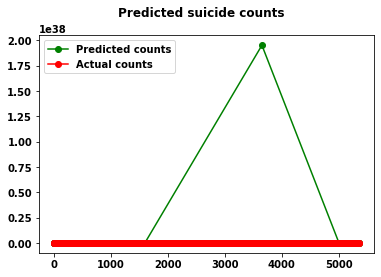

In [83]:
fig = plt.figure()
fig.suptitle('Predicted suicide counts')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, y_test, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

As we see, our metrics show greater error (RMSLE) and inferior R^2.

So, this first Poisson model is **inferior to the chosen baseline.**

---

Next steps:

- Model as Negative Binomial Regression (doesn't imply that the mean and variance are equal)

- Consider other variables in the model (CAPITAL, LATITUDE, LONGITUDE, ALTITUDE, AREA) in order to understand better the data (don't forget to cast to positive numbers)

- Try with other diseases